In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Defining the path to the provided ZIP file in my Google Drive
zip_path = '/content/drive/My Drive/Colab Notebooks/cats_vs_dogs_small.zip'

# Defining extracted files path into My Google Drive Folder
extract_path = "/content/drive/My Drive/Colab Notebooks/"

# Unzipping the files quietely
!unzip -q "{zip_path}" -d "{extract_path}"

print("Files unzipped successfully")

Files unzipped successfully


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shutil
import pathlib
import matplotlib.pyplot as plt

# Defining Original Base Directory
original_base_dir = pathlib.Path("/content/drive/My Drive/Colab Notebooks/cats_vs_dogs_small")
# Defining Original Base Subdirectories
original_train_dir = original_base_dir / "train"
original_validation_dir = original_base_dir / "validation"
original_test_dir = original_base_dir / "test"

# Dictionary to store all the results
results = {}

In [4]:
# Defining Subsets
def make_subset(subset_name, train_size, validation_size, test_size):
    new_base_dir = pathlib.Path(f"/content/{subset_name}")
    if new_base_dir.exists():
        shutil.rmtree(new_base_dir)

    print(f"Creating new dataset subset: {new_base_dir}")

    # Helper function to copy files
    def copy_files(src_dir, dst_dir, num_files):
        os.makedirs(dst_dir, exist_ok=True)
        # List all files in the source directory
        all_files = sorted([f for f in os.listdir(src_dir) if os.path.isfile(src_dir / f)])
        # Copy the first 'num_files' from the list
        files_to_copy = all_files[:num_files]
        for fname in files_to_copy:
            src_file = src_dir / fname
            shutil.copyfile(src_file, dst_dir / fname)
        print(f"Copied {len(files_to_copy)} files from {src_dir} to {dst_dir}")


    # --- Creating Training Set ---
    copy_files(original_train_dir / "cats", new_base_dir / "train" / "cats", train_size // 2)
    copy_files(original_train_dir / "dogs", new_base_dir / "train" / "dogs", train_size // 2)

    # --- Creating Validation Set ---
    copy_files(original_validation_dir / "cats", new_base_dir / "validation" / "cats", validation_size // 2)
    copy_files(original_validation_dir / "dogs", new_base_dir / "validation" / "dogs", validation_size // 2)

    # --- Creating Test Set ---
    copy_files(original_test_dir / "cats", new_base_dir / "test" / "cats", test_size // 2)
    copy_files(original_test_dir / "dogs", new_base_dir / "test" / "dogs", test_size // 2)


    return new_base_dir

In [5]:
# Loading Datasets
def get_datasets(base_dir, image_size=(180, 180), batch_size=32):
    train_dataset = keras.utils.image_dataset_from_directory(
        base_dir / "train",
        image_size=image_size,
        batch_size=batch_size
    )
    validation_dataset = keras.utils.image_dataset_from_directory(
        base_dir / "validation",
        image_size=image_size,
        batch_size=batch_size
    )
    test_dataset = keras.utils.image_dataset_from_directory(
        base_dir / "test",
        image_size=image_size,
        batch_size=batch_size
    )
    return train_dataset, validation_dataset, test_dataset

def plot_history(history, title):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.suptitle(title, y=1.02)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.show()

In [6]:
# Q1,2,3
# Creating Subsets

# Step 1 subset: Train=1000, Val=500, Test=500
subset_1_dir = make_subset("subset_1000_500_500",
                           train_size=1000,
                           validation_size=500,
                           test_size=500)

# Step 2 subset: Train=2000, Val=500, Test=500
subset_2_dir = make_subset("subset_2000_500_500",
                           train_size=2000,
                           validation_size=500,
                           test_size=500)

# Step 3 subset: "Ideal" size (using full original dataset)
subset_3_dir = make_subset("subset_2000_1000_1000",
                           train_size=2000,
                           validation_size=1000,
                           test_size=1000)

#  Loading new subsetted datasets
print("\nLoading datasets...")
train_ds_1, val_ds_1, test_ds_1 = get_datasets(subset_1_dir)
train_ds_2, val_ds_2, test_ds_2 = get_datasets(subset_2_dir)
train_ds_3, val_ds_3, test_ds_3 = get_datasets(subset_3_dir)

Creating new dataset subset: /content/subset_1000_500_500
Copied 500 files from /content/drive/My Drive/Colab Notebooks/cats_vs_dogs_small/train/cats to /content/subset_1000_500_500/train/cats
Copied 500 files from /content/drive/My Drive/Colab Notebooks/cats_vs_dogs_small/train/dogs to /content/subset_1000_500_500/train/dogs
Copied 250 files from /content/drive/My Drive/Colab Notebooks/cats_vs_dogs_small/validation/cats to /content/subset_1000_500_500/validation/cats
Copied 250 files from /content/drive/My Drive/Colab Notebooks/cats_vs_dogs_small/validation/dogs to /content/subset_1000_500_500/validation/dogs
Copied 250 files from /content/drive/My Drive/Colab Notebooks/cats_vs_dogs_small/test/cats to /content/subset_1000_500_500/test/cats
Copied 250 files from /content/drive/My Drive/Colab Notebooks/cats_vs_dogs_small/test/dogs to /content/subset_1000_500_500/test/dogs
Creating new dataset subset: /content/subset_2000_500_500
Copied 1000 files from /content/drive/My Drive/Colab Noteb

In [7]:
# Building Scratch Model
def build_model_from_scratch():

    # Data Augmentation layers
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ]
    )

    # Model Architecture
    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augmentation(inputs)

    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.Flatten()(x)

    # Dropout for regularization
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compiling the model
    model.compile(loss="binary_crossentropy",
                  optimizer="rmsprop",
                  metrics=["accuracy"])

    return model

In [8]:
def train_and_evaluate_scratch(subset_name, train_ds, val_ds, test_ds):

    print(f"\n--- Training Scratch Model on {subset_name} ---")

    keras.backend.clear_session() # Resets model
    model = build_model_from_scratch()

    checkpoint_filepath = f"{subset_name}_scratch.keras"
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_best_only=True,
            monitor="val_loss")
    ]

    # Training for 100 epochs, as provided in the sample notebook
    history = model.fit(
        train_ds,
        epochs=100,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1)

    print("Training complete. Plotting results...")
    plot_history(history, f"Scratch Model: {subset_name}")

    # Loading the best performing model (saved by ModelCheckpoint)
    print("Evaluating best model on test set...")
    test_model = keras.models.load_model(checkpoint_filepath)
    test_loss, test_acc = test_model.evaluate(test_ds)
    print(f"Test accuracy for {subset_name}: {test_acc:.4f}")

    return test_acc


--- Training Scratch Model on subset_1000_500_500 ---
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.5115 - loss: 0.8564 - val_accuracy: 0.5460 - val_loss: 0.6928
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.4980 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.5215 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.5213 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6916
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5507 - loss: 0.7033 - val_accuracy: 0.5140 - val_loss: 0.6866
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5371 - loss: 0.6851 - val_accuracy: 0.6080 - val_loss: 0.6667
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5861 - loss: 0.6753 - val_accuracy: 0.5100 - val_loss: 0.7212
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/st

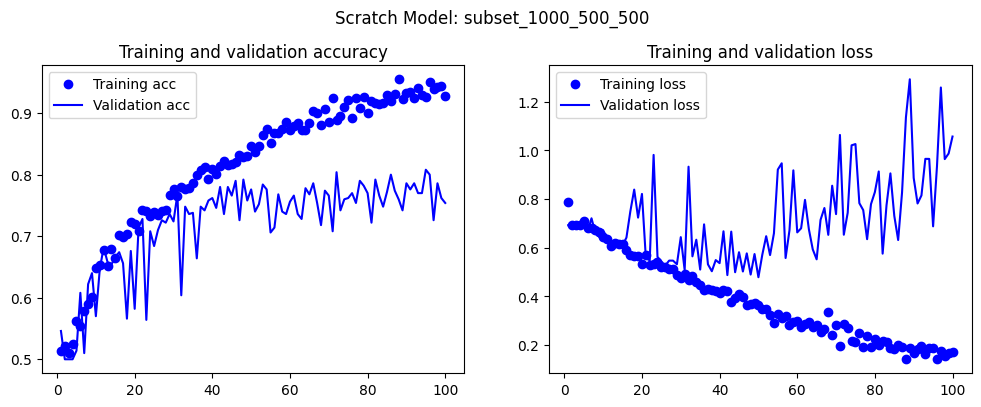

Evaluating best model on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7479 - loss: 0.6021
Test accuracy for subset_1000_500_500: 0.7580

--- Training Scratch Model on subset_2000_500_500 ---
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.4927 - loss: 0.6991 - val_accuracy: 0.5000 - val_loss: 0.7061
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5343 - loss: 0.6936 - val_accuracy: 0.5080 - val_loss: 0.6893
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5583 - loss: 0.6883 - val_accuracy: 0.5800 - val_loss: 0.6739
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.5527 - loss: 0.6797 - val_accuracy: 0.6320 - val_loss: 0.6548
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6105 - loss: 0.6704 - val_accuracy: 0.6360 - val_loss: 0.6467
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6306 - loss: 0.6388 - val_accuracy: 0.6740 - val_loss: 0.6293
Epoch 7/100
63/63 ━━

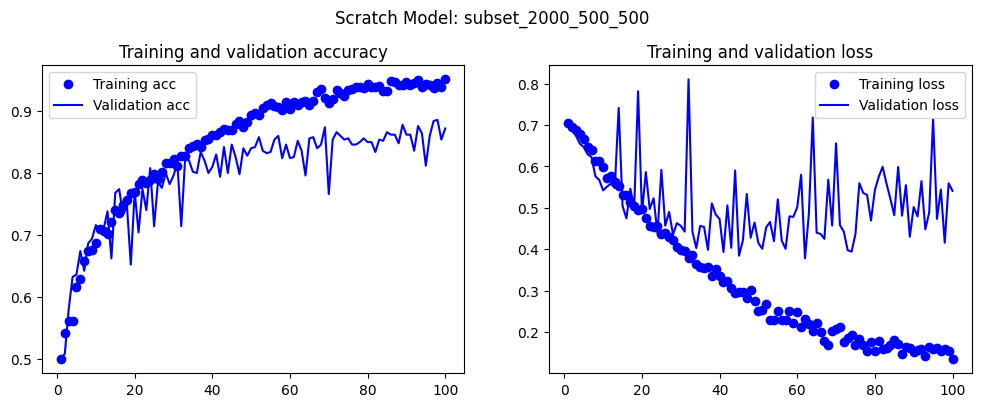

Evaluating best model on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8194 - loss: 0.7273
Test accuracy for subset_2000_500_500: 0.8400

--- Training Scratch Model on subset_2000_1000_1000 ---
Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.5141 - loss: 0.6999 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5070 - loss: 0.6937 - val_accuracy: 0.5070 - val_loss: 0.6920
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.5181 - loss: 0.6944 - val_accuracy: 0.5660 - val_loss: 0.6847
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5469 - loss: 0.6910 - val_accuracy: 0.6280 - val_loss: 0.6570
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6244 - loss: 0.6562 - val_accuracy: 0.5730 - val_loss: 0.6764
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.6174 - loss: 0.6567 - val_accuracy: 0.6330 - val_loss: 0.6424
Epoch 7/100
63/63 

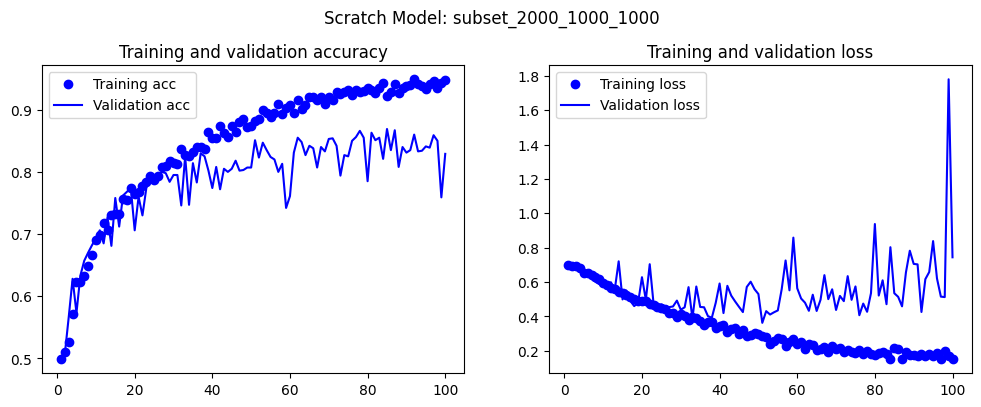

Evaluating best model on test set...
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8223 - loss: 0.4727
Test accuracy for subset_2000_1000_1000: 0.8250

Scratch Model Results So Far:
{'scratch_1000': 0.7580000162124634, 'scratch_2000': 0.8399999737739563, 'scratch_ideal': 0.824999988079071}


In [9]:
# Step 1: Train=1000, Val=500, Test=500
results["scratch_1000"] = train_and_evaluate_scratch(
    "subset_1000_500_500", train_ds_1, val_ds_1, test_ds_1)

# Step 2: Train=2000, Val=500, Test=500
results["scratch_2000"] = train_and_evaluate_scratch(
    "subset_2000_500_500", train_ds_2, val_ds_2, test_ds_2)

# Step 3: Train=2000, Val=1000, Test=1000 (The "ideal" from sample)
results["scratch_ideal"] = train_and_evaluate_scratch(
    "subset_2000_1000_1000", train_ds_3, val_ds_3, test_ds_3)

print("\nScratch Model Results So Far:")
print(results)

From Step 1 to 2, Increasing training data from 1,000 → 2,000 improved test accuracy substantially (0.758 → 0.840). In Step 3, The 'ideal' run used the same training amount as Step 2 (2,000) but larger validation/test splits; test accuracy for that run was slightly lower (0.825), likely because the larger test set is a stricter estimate and/or because of variance in which images were selected.

In [10]:
def build_and_train_pretrained(subset_name, train_ds, val_ds, test_ds):

    print(f"\n--- Training Pretrained Model on {subset_name} ---")

    keras.backend.clear_session()

    # 1. Loading VGG16 base, frozen
    conv_base = keras.applications.vgg16.VGG16(
        weights="imagenet",
        include_top=False,
        input_shape=(180, 180, 3))
    conv_base.trainable = False

    # 2. Adding augmentation, classifier head
    data_augmentation = keras.Sequential(
        [layers.RandomFlip("horizontal"),
         layers.RandomRotation(0.1),
         layers.RandomZoom(0.2)]
    )

    inputs = keras.Input(shape=(180, 180, 3))
    x = data_augmentation(inputs)
    x = keras.applications.vgg16.preprocess_input(x)
    x = conv_base(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    # 3. --- PHASE 1: FEATURE EXTRACTION ---
    print("... Phase 1: Training classifier head ...")
    checkpoint_filepath_phase1 = f"{subset_name}_pretrained_phase1.keras"
    callbacks_phase1 = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath_phase1,
            save_best_only=True,
            monitor="val_loss")
    ]

    model.compile(loss="binary_crossentropy",
                  optimizer="rmsprop",
                  metrics=["accuracy"])

    history_phase1 = model.fit(
        train_ds,
        epochs=50, # Training classifier for 50 epochs
        validation_data=val_ds,
        callbacks=callbacks_phase1,
        verbose=0)

    print("Phase 1 complete. Plotting results...")
    plot_history(history_phase1, f"Pretrained (Phase 1): {subset_name}")

    # 4. --- PHASE 2: FINE-TUNING ---
    print("... Phase 2: Fine-tuning ...")
    model = keras.models.load_model(checkpoint_filepath_phase1) # Loading best model

    # Unfreeze the top layers of VGG16
    conv_base.trainable = True
    for layer in conv_base.layers[:-4]:
        layer.trainable = False

    checkpoint_filepath_phase2 = f"{subset_name}_pretrained_phase2.keras"
    callbacks_phase2 = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath_phase2,
            save_best_only=True,
            monitor="val_loss")
    ]

    # Re-compiling with a very low learning rate
    model.compile(loss="binary_crossentropy",
                  optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                  metrics=["accuracy"])

    history_phase2 = model.fit(
        train_ds,
        epochs=30, # Fine-tune for 30 epochs
        validation_data=val_ds,
        callbacks=callbacks_phase2,
        verbose=0)

    print("Phase 2 complete. Plotting results...")
    plot_history(history_phase2, f"Pretrained (Phase 2 Fine-Tune): {subset_name}")

    # 5. --- FINAL EVALUATION ---
    print("Evaluating best model on test set...")
    test_model = keras.models.load_model(checkpoint_filepath_phase2) # Loading best model
    test_loss, test_acc = test_model.evaluate(test_ds)
    print(f"Test accuracy for {subset_name}: {test_acc:.4f}")

    return test_acc


--- Training Pretrained Model on subset_1000_500_500 ---
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
... Phase 1: Training classifier head ...
Phase 1 complete. Plotting results...


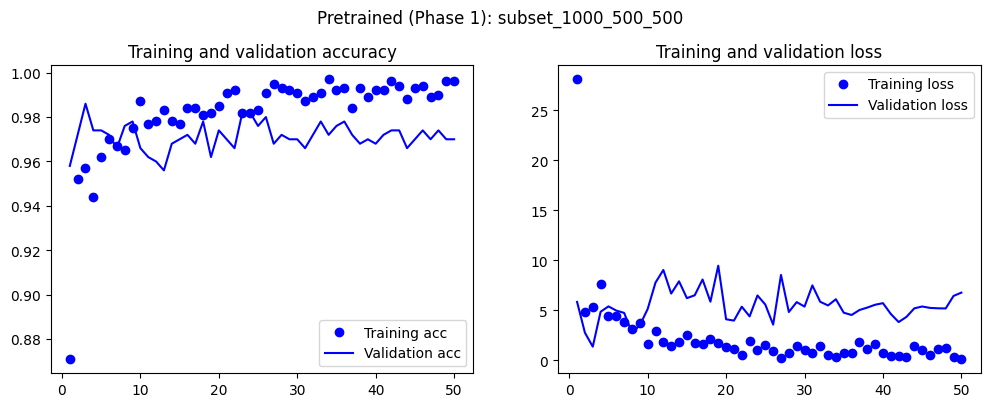

... Phase 2: Fine-tuning ...
Phase 2 complete. Plotting results...


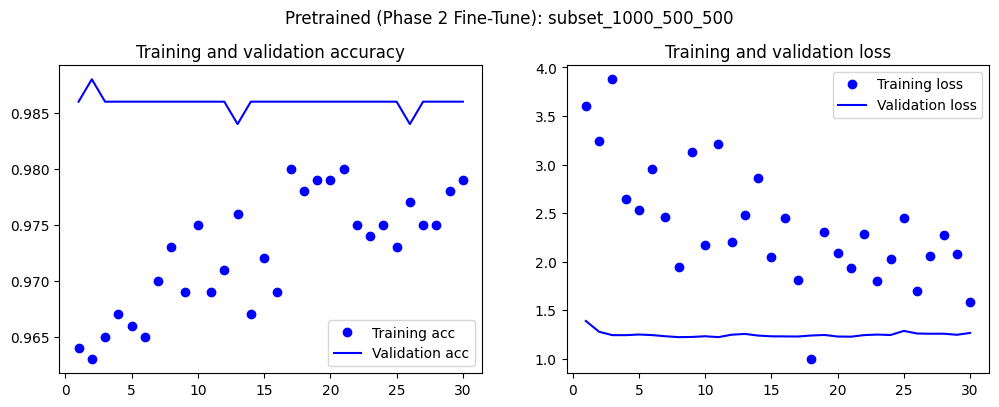

Evaluating best model on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9635 - loss: 7.9123
Test accuracy for subset_1000_500_500: 0.9660

--- Training Pretrained Model on subset_2000_500_500 ---
... Phase 1: Training classifier head ...
Phase 1 complete. Plotting results...


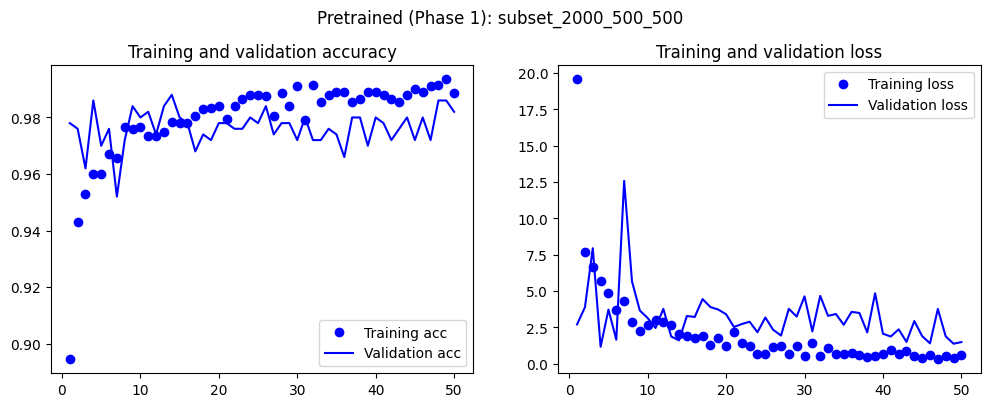

... Phase 2: Fine-tuning ...
Phase 2 complete. Plotting results...


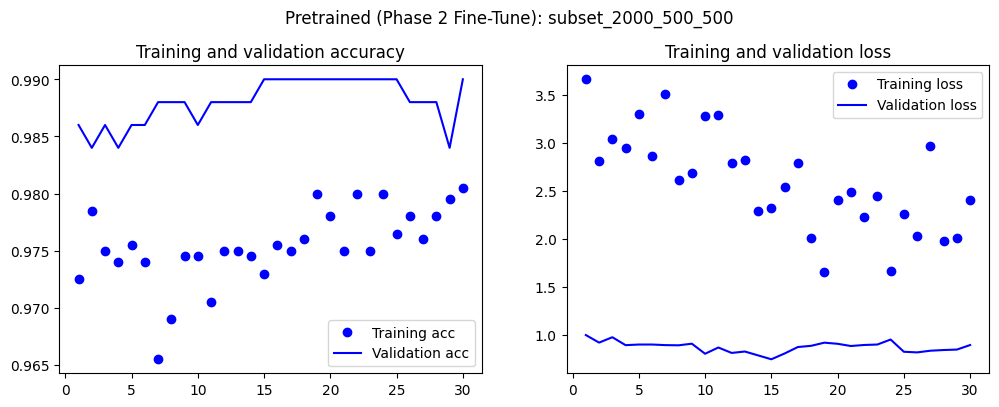

Evaluating best model on test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9690 - loss: 4.3518
Test accuracy for subset_2000_500_500: 0.9740

--- Training Pretrained Model on subset_2000_1000_1000 ---
... Phase 1: Training classifier head ...
Phase 1 complete. Plotting results...


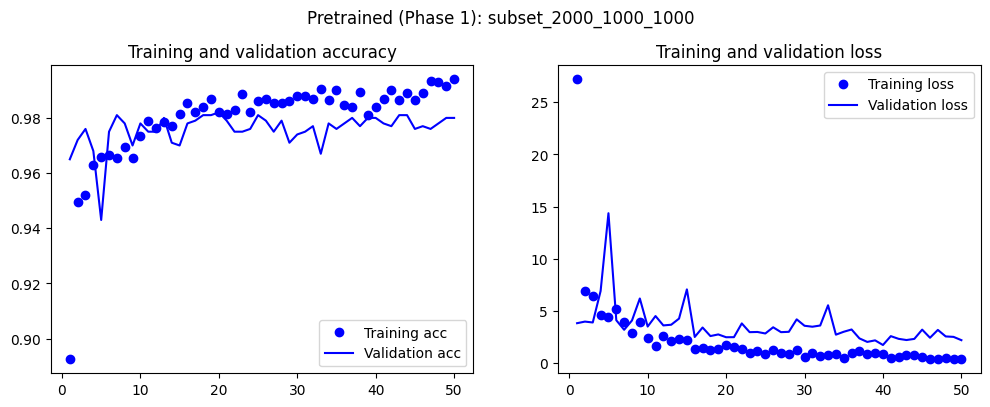

... Phase 2: Fine-tuning ...
Phase 2 complete. Plotting results...


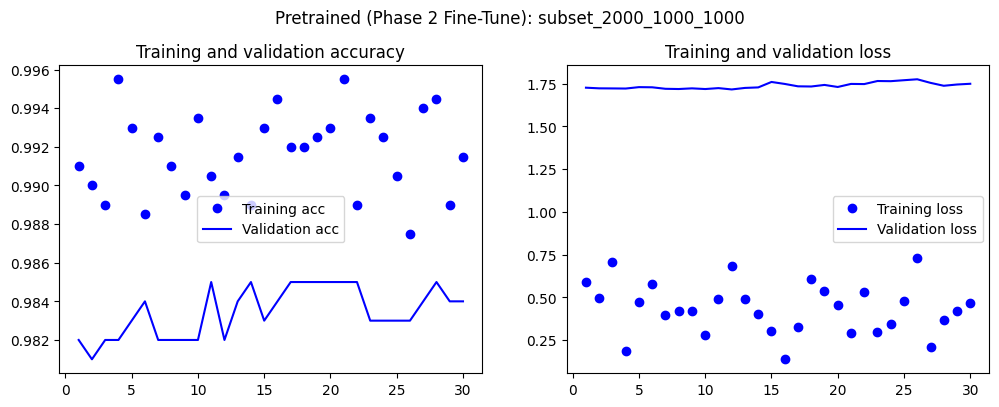

Evaluating best model on test set...
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.9870 - loss: 1.4562
Test accuracy for subset_2000_1000_1000: 0.9830


In [11]:
# --- Running the Pretrained Experiments ---

# Step 4 (part 1): Train=1000, Val=500, Test=500
results["pretrained_1000"] = build_and_train_pretrained(
    "subset_1000_500_500", train_ds_1, val_ds_1, test_ds_1)

# Step 4 (part 2): Train=2000, Val=500, Test=500
results["pretrained_2000"] = build_and_train_pretrained(
    "subset_2000_500_500", train_ds_2, val_ds_2, test_ds_2)

# Step 4 (part 3): Train=2000, Val=1000, Test=1000 (The "ideal")
results["pretrained_ideal"] = build_and_train_pretrained(
    "subset_2000_1000_1000", train_ds_3, val_ds_3, test_ds_3)

In Step 4, Transfer learning (pretrained VGG16 + fine-tuning) outperformed the model trained from scratch by a large margin for all sample sizes. Even with only 1,000 training images, the pretrained model reached ~96.6% test accuracy, whereas the scratch model reached ~75.8%. Also noticeably, Pretrained models improved significantly with more train data (96.6% → 97.4% → 98.3%), indicating diminishing returns but still measurable gains from additional labeled data when combined with transfer learning and fine-tuning.

In [12]:
print("\n\n--- FINAL RESULTS ---")
print(results)



--- FINAL RESULTS ---
{'scratch_1000': 0.7580000162124634, 'scratch_2000': 0.8399999737739563, 'scratch_ideal': 0.824999988079071, 'pretrained_1000': 0.9660000205039978, 'pretrained_2000': 0.9739999771118164, 'pretrained_ideal': 0.9829999804496765}
